In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import random
import seaborn as sns
import itertools
import os
from PIL import Image
import math
from matplotlib import gridspec
import matplotlib.collections

from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import matplotlib.collections

from sklearn.model_selection import *

from tqdm import *
# nice progress bars otherwise
# def tqdm(x):
#     yield x


import keras
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *

import pandas as pd
import numpy as np
import cv2
from glob import glob
import xgboost as xgb
from keras.applications import *
import lightgbm as lgbm
import scipy
import tensorflow

Using TensorFlow backend.
/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# TODO, improvement ideas

# TPOT python auto ml
# use log(flux) as input
# investigate highest errors (argmax(xi²))

# kfold integration in place of CV
# TTA
# CNN segmentation cleanup 
# resnet v2 ( https://github.com/myutwo150/keras-inception-resnet-v2/blob/master/inception_resnet_v2.py )
# custom CNN features
# CV2 resize cubic interpolation 

# Serge:
# essayer de remplacer lgb par un Deep NN keras (vu la quantité de donnée)


#done
# lgbm eval rmsle instead of rmse
# add image size as feature



In [3]:
# memory debug function

import sys
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
mm = sorted([(x, sys.getsizeof(globals().get(x)),"{:,}".format(sys.getsizeof(globals().get(x)))) 
        for x in dir() 
           if not x.startswith('_') 
#         and x not in sys.modules
        and x not in ipython_vars], key=lambda x: x[1], reverse=True)




## data folder set up and test

In [4]:
dataFolder = 'data/mainData/'
plt.ion()

runNameParams = []
runNameParams.append('newSource')
# print(runNameParams)

In [5]:
def read_image(idd):
    id = str(idd)
    if id[-4:] == '.npy':
        X = np.load(dataFolder+id)
    elif os.path.isfile(dataFolder+id+'.npy'):
        X = np.load(dataFolder+id + '.npy')
    elif os.path.isfile(dataFolder+id+'-g.csv'):
        X = np.genfromtxt(dataFolder+id+'-g.csv', delimiter=",")
    else:
        X = None

    X = np.float32(X)
    return X


In [6]:
dataFileList = []

directory = os.fsencode(dataFolder)

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".npy") or filename.endswith(".py"): 
        dataFileList.append(filename)
        
print(len(dataFileList))

80306


# Check a few random images 


In [7]:
def drawOneGalaxy(galaxyID):
    oneImageData = read_image(galaxyID)
    print(galaxyID)

    # new image
    fig = plt.figure(figsize=(15,15))
    #set grid spec for the 4 graphs
    gs = gridspec.GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1,5]) 

    #draw image
    plt.title("raw")
    plt.subplot(gs[2])
    plt.imshow(oneImageData)
    
    # horizontal (top) sum
    plt.subplot(gs[0])
    plt.title(galaxyID)
    plt.plot(oneImageData.sum(axis=0))

    # vertical (bottom-right) sum
    ax = plt.subplot(gs[3])
    ss = np.flip(oneImageData.sum(axis=1),axis=0)
    plt.scatter(x=ss, y=list(range(oneImageData.shape[1])), s=1)
    lines = [[(ss[i-1],i-1),(ss[i],i)] for i in range(1,len(ss))]
    lc = matplotlib.collections.LineCollection(lines)
    ax.add_collection(lc)
    
    #value histogram
    plt.subplot(gs[1])
    plt.hist(oneImageData.reshape(-1), bins=100)
    plt.yscale('log')    
    sns.despine()
    plt.tight_layout()

    #add small log of image
    ax = fig.add_axes([0.02,0.6,.2,.2])
    plt.imshow(np.log(oneImageData-oneImageData.min()+0.00001))

for _ in range(5):
    i = random.randint(0,len(dataFileList))
#     oneImageData = np.load(dataFolder+'1237648704067273096.npy')
#     drawOneGalaxy(dataFileList[i])
    


In [8]:

issuesImages = ['1237658298983055529.npy','1237660634917634181.npy','1237654879654772871.npy','1237654953205170487.npy','1237651249884627014.npy','1237651754022207627.npy',
 '1237654669736018114.npy','1237655471824568727.npy','1237665530643808416.npy','1237658611444088911.npy','1237667255070490937.npy',
 '1237665531177795774.npy','1237645943975837722.npy','1237658425161220139.npy', '1237665129087435003.npy','1237657873792172224.npy',
 '1237660240313778264.npy','1237668298201432152.npy', '1237662264316264518.npy','1237657630042227294.npy','1237651754550624376.npy',
 '1237667211059986578.npy','1237655470208582145.npy']

# for image in issuesImages:
#     drawOneGalaxy(image)

In [9]:
print('test')

test


# ML part

In [10]:
def xi2(true,pred,error):
    s=np.mean((true-pred)**2/error**2)
    return s

def normalize_image(Xg):
    Xg -= np.mean(Xg)
    Xg /= np.std(Xg)
    
    return Xg

def crop_image(Xg):
    h,w = Xg.shape
    cy, cx = h//2, w//2
    dy, dx = int(cy*0.75), int(cx*0.75) # crop a bit around center
    Xg = Xg[cy-dy:cy+dy,cx-dx:cx+dx]
    
    return Xg

def img_preprocnoread(Xg, preProcNum = 0):
#    Xg = cleanupImage(id)

    if ( preProcNum != 0):
        if preProcNum & 4: # rotate
            Xg = np.rot90(Xg)
            
        if preProcNum %4 == 1: # vflip
            Xg = np.flip(Xg,0)
        elif preProcNum %4 == 2: # hflip
            Xg = np.flip(Xg,1)
        elif preProcNum %4 == 3: # hflip+vflip
            Xg = np.flip(np.flip(Xg,1),0)

    Xg = np.log1p(Xg - Xg.min())
    Xg = normalize_image(Xg)
    
    Xg = (Xg-Xg.min())/(Xg.max()-Xg.min())
    Xg = crop_image(Xg)

    
    if Xg.shape[0] >= 224:
        Xgr = cv2.resize(Xg,(224,224), cv2.INTER_AREA)
    else:
        Xgr = cv2.resize(Xg,(224,224), cv2.INTER_CUBIC)
    
    return Xgr
    
def img_preproc(id, preProcNum = 0):
    Xg = read_image(id)
    return img_preprocnoread(Xg,preProcNum)

runNameParams.append('ReadLog1pNormCrop.75')
# preprocName = "ReadNormCrop.5"
# x = img_preproc('1237662637444694216')
x = img_preproc(dataFileList[random.randint(0,len(dataFileList))])


0.0177393 0.960107
[[ 0.0747754   0.08551675  0.09654727  0.08122215  0.07404243]
 [ 0.08554168  0.09135284  0.09681182  0.08471952  0.08269608]
 [ 0.09925841  0.09913325  0.0977584   0.08862233  0.09243148]
 [ 0.10378237  0.10416375  0.10242499  0.08595894  0.08642867]
 [ 0.1021146   0.10346904  0.10240278  0.08210637  0.07685142]]


1

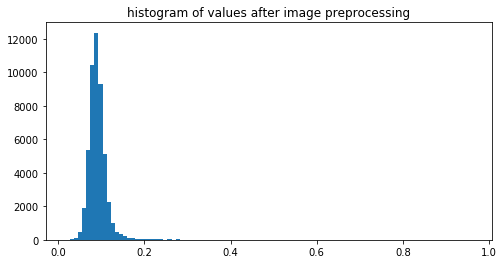

In [11]:
print(x.min(), x.max())
print(x[0:5,0:5])

plt.figure(figsize=(8,4))
plt.title('histogram of values after image preprocessing')
plt.hist(x.reshape(-1), bins=100)

1

### Load pretrained networks

In [12]:
# vgg16 = VGG16(weights='imagenet',include_top=True,input_shape=(224,224,3))
# r50 = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))

### Read metadata file

In [13]:
df =  pd.read_fwf('metaData.dat', comment = '#')
# df.columns = df.iloc[9,:].values
df = df[10:]
df.head()

,SDSS_ID,RA,DEC,D25,redshi,logMst,err_l,GalSize_kpc,D_Mpc,d_pix_kpc,ML_g,ML_i,ML_g_rel_err,ML_i_rel_err
10,1237661417675358319,212.00235,54.64712,0.346737,0.0425,9.321,0.073,18.371232,182.142859,0.353221,0.552346,0.824044,0.1693176524709065,0.17027912681005078
11,1237652947989954674,2.76375,-9.65117,0.676083,0.0219,9.792,0.024,18.458374,93.857143,0.182013,0.931264,1.295889,0.055727677337726475,0.0565927830302514
12,1237650760781856869,184.31535,-3.14031,0.363078,0.1104,10.924,0.031,49.971042,473.142852,0.917545,5.167004,3.429270,0.07339518946801954,0.07241900082138769
13,1237662663742521513,212.44140,37.53058,0.870964,0.0360,9.255,0.075,39.088753,154.285708,0.299199,0.461905,0.844912,0.17617836523767158,0.19154073787547918
14,1237661433243238619,212.49180,43.06500,0.478630,0.0698,10.835,0.010,41.649016,299.142844,0.580114,3.243922,2.999116,0.024119352618723746,0.02443118526495806


In [14]:
df['RA'] = df['RA'].apply(np.float64)
df['DEC'] = df['DEC'].apply(np.float64)
df['D25'] = df['D25'].apply(np.float64)
df['redshi'] = df['redshi'].apply(np.float64)
df['logMstar'] = df['logMst'].apply(np.float64) #renamed
df['err_logMstar'] = df['err_l'].apply(np.float64) #renamed
df['GalSize_kpc'] = df['GalSize_kpc'].apply(np.float64)
df['Distance'] = df['D_Mpc'].apply(np.float64) #renamed
df['d_pix_kpc'] = df['d_pix_kpc'].apply(np.float64)

df['lin_mass'] = np.power(10, df.logMstar)
df['lin_err'] = df['lin_mass'] * np.log(10) * df.err_logMstar

df = df.drop(['logMst','err_l'], axis=1)
df.describe()

,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,ML_g,ML_i,logMstar,err_logMstar,Distance,lin_mass,lin_err
count,1.877320e+05,187732.000000,187732.000000,187732.000000,187732.000000,187732.000000,187732.000000,187732.000000,1.877320e+05,1.877320e+05,187732.000000,187732.000000,187732.000000,1.877320e+05,1.877320e+05
mean,1.237661e+18,184.530599,24.898792,0.445797,0.074652,38.318375,319.938804,0.620443,1.344585e+02,2.276468e+02,9.082473,-1.313176,319.938804,7.877955e+10,4.648265e+09
std,6.148425e+12,61.615665,19.374003,0.168008,0.040143,18.942479,172.043473,0.333636,3.042216e+04,4.315226e+04,12.704441,11.467822,172.043473,9.461907e+10,5.529091e+09
min,1.237646e+18,0.008250,-11.252830,0.316228,0.010000,4.034125,42.857142,0.083111,0.000000e+00,0.000000e+00,-99.000000,-99.000000,42.857142,1.000000e-99,-2.279559e-97
25%,1.237657e+18,152.351175,8.662297,0.346737,0.044100,25.157782,189.000006,0.366519,1.510196e+00,1.671054e+00,10.191000,0.021000,189.000006,1.552387e+10,1.145440e+09
50%,1.237662e+18,185.824575,23.197910,0.389045,0.069000,35.525868,295.714278,0.573465,2.795447e+00,2.384673e+00,10.693000,0.029000,295.714278,4.931738e+10,2.906887e+09
75%,1.237665e+18,222.153037,39.835162,0.478630,0.096400,48.283920,413.142858,0.801189,3.940565e+00,2.978745e+00,11.032000,0.041000,413.142858,1.076465e+11,6.027756e+09
max,1.237681e+18,359.994900,70.133250,10.964781,0.299600,1373.931687,1284.000022,2.490003,1.034487e+07,1.346961e+07,12.326000,0.800000,1284.000022,2.118361e+12,1.727792e+11


In [15]:
# df.SDSS_ID[:20].apply(lambda x: x)
df['hasFile'] = df.SDSS_ID.apply(lambda x: os.path.isfile(dataFolder+str(x)+'.npy'))

print("data file present:", len(df[df['hasFile']==True]))
print("data file missing:", len(df[df['hasFile']==False]))

data file present: 80306
data file missing: 107426


### Filter images that have no known mass, no actual image, or with an unknown error

In [16]:
df = df[df.logMstar != -99]
df = df[df.hasFile == True]
df = df[df['lin_err']!=0]
df.describe()

,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,ML_g,ML_i,logMstar,err_logMstar,Distance,lin_mass,lin_err
count,7.885100e+04,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,78851.000000,7.885100e+04,78851.000000,78851.000000,78851.000000,78851.000000,7.885100e+04,7.885100e+04
mean,1.237662e+18,185.303775,25.672447,0.557644,0.058701,38.101843,251.574576,0.487867,1.071682e+02,27.921373,10.558197,0.031070,251.574576,7.898269e+10,4.398954e+09
std,5.871112e+12,57.111612,18.944782,0.194465,0.032567,19.838329,139.570856,0.270663,2.249827e+04,4666.990961,0.654456,0.016953,139.570856,9.624108e+10,5.552716e+09
min,1.237646e+18,0.009450,-11.238420,0.407380,0.010000,5.248929,42.857142,0.083111,0.000000e+00,0.000000,7.376000,0.001000,42.857142,2.376840e+07,4.756699e+05
25%,1.237658e+18,154.486425,9.795145,0.436516,0.033800,24.390653,144.857136,0.280915,1.564197e+00,1.720133,10.200000,0.019000,144.857136,1.584893e+10,1.023221e+09
50%,1.237662e+18,186.753000,24.400580,0.489779,0.052300,35.043089,224.142852,0.434670,2.703627e+00,2.334827,10.692000,0.028000,224.142852,4.920395e+10,2.693666e+09
75%,1.237665e+18,221.979375,40.093400,0.602560,0.075600,47.500516,323.999992,0.628319,3.660819e+00,2.872725,11.030000,0.039000,323.999992,1.071519e+11,5.603185e+09
max,1.237680e+18,359.994900,70.133250,10.964781,0.294800,1373.931687,1263.428628,2.450110,6.191119e+06,934654.964691,12.326000,0.778000,1263.428628,2.118361e+12,1.414535e+11


In [17]:
random.seed(42)

# df = df.sample(frac=1).reset_index(drop=True)

In [18]:
df.head()

,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,ML_g,ML_i,ML_g_rel_err,ML_i_rel_err,logMstar,err_logMstar,Distance,lin_mass,lin_err,hasFile
174,1237662301367173202,231.31860,41.34601,0.512861,0.0761,48.655727,326.142854,0.632474,2.472975,2.279201,0.10538494430763483,0.10490392881262686,10.325,0.045,326.142854,2.113489e+10,2.189920e+09,True
216,1237662301905813735,236.00985,39.28830,0.446684,0.0685,38.145197,293.571417,0.569310,0.841365,1.148099,0.0937583775777785,0.09498951605786418,9.824,0.040,293.571417,6.668068e+09,6.141517e+08,True
237,1237662534360301834,237.49500,9.27861,0.630957,0.0390,30.677076,167.142861,0.324133,0.703785,1.051369,0.12275435787589066,0.12327084107474802,9.923,0.053,167.142861,8.375293e+09,1.022096e+09,True
276,1237662500543987740,242.00880,36.05398,0.562341,0.0658,46.129129,282.000016,0.546870,1.248502,1.269311,0.18337669095071935,0.1837691489095808,10.356,0.079,282.000016,2.269865e+10,4.128980e+09,True
332,1237662474232398001,246.28905,29.94774,0.446684,0.0455,25.337321,194.999996,0.378155,0.419816,0.559744,0.21992004649415212,0.2194701990290622,9.234,0.094,194.999996,1.713957e+09,3.709741e+08,True


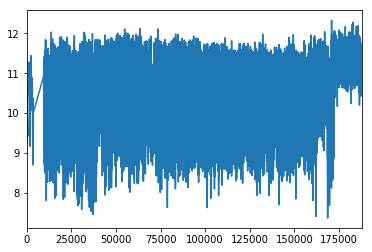

In [19]:
df.logMstar.plot()

In [20]:
print(len(df.SDSS_ID.values))

78851


In [21]:
# crap instruction to make the auto execution stop here :p

# Petit chaaat

### Generate features based on the preprocessed images, CNN networkand flux densities

In [22]:
print(df.shape)
df.head()

(78851, 18)


,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,ML_g,ML_i,ML_g_rel_err,ML_i_rel_err,logMstar,err_logMstar,Distance,lin_mass,lin_err,hasFile
174,1237662301367173202,231.31860,41.34601,0.512861,0.0761,48.655727,326.142854,0.632474,2.472975,2.279201,0.10538494430763483,0.10490392881262686,10.325,0.045,326.142854,2.113489e+10,2.189920e+09,True
216,1237662301905813735,236.00985,39.28830,0.446684,0.0685,38.145197,293.571417,0.569310,0.841365,1.148099,0.0937583775777785,0.09498951605786418,9.824,0.040,293.571417,6.668068e+09,6.141517e+08,True
237,1237662534360301834,237.49500,9.27861,0.630957,0.0390,30.677076,167.142861,0.324133,0.703785,1.051369,0.12275435787589066,0.12327084107474802,9.923,0.053,167.142861,8.375293e+09,1.022096e+09,True
276,1237662500543987740,242.00880,36.05398,0.562341,0.0658,46.129129,282.000016,0.546870,1.248502,1.269311,0.18337669095071935,0.1837691489095808,10.356,0.079,282.000016,2.269865e+10,4.128980e+09,True
332,1237662474232398001,246.28905,29.94774,0.446684,0.0455,25.337321,194.999996,0.378155,0.419816,0.559744,0.21992004649415212,0.2194701990290622,9.234,0.094,194.999996,1.713957e+09,3.709741e+08,True


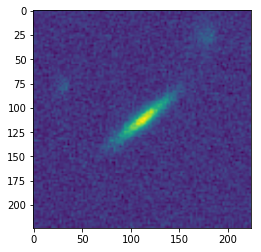

In [23]:
plt.imshow(img_preproc('1237662301367173202'))

In [24]:
img_preproc('1237662301367173202').shape

(224, 224)

In [25]:
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [26]:
df = df.sample(frac =1)

train = df.iloc[0:int(df.shape[0] * 0.8 ), :]
test = df.iloc[int(df.shape[0] * 0.8 ):, :]
print(train.shape)
print(test.shape)

(63080, 18)
(15771, 18)


In [27]:


model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(224, 224,1)))
model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Convolution2D(32, 3, 3))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Convolution2D(64, 3, 3))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
# model.add(Dropout(0.5))
model.add(Dense(1))
# model.add(Activation('elu'))

In [28]:
model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])

In [29]:
nb_epoch = 1
nb_train_samples = 2048
nb_validation_samples = 832

In [30]:
from IPython.display import clear_output
step = 100
x_test= np.stack([ img_preproc(x) for x in test.SDSS_ID.values[0: step]])
x_test = x_test[:, :, :, newaxis]
y_test = test.logMstar.values[0: step]
print(x_test.shape)

(100, 224, 224, 1)


In [31]:
for i in range(0, 20, 10):
    x_train = np.stack([ img_preproc(x) for x in train.SDSS_ID.values[i: (i + 10)]])
    x_train = x_train[:, :, :, newaxis]
    print(x_train.shape)
    y = train.logMstar.values[i: (i + 10)]
    model.fit(x = x_train, y = y,epochs = nb_epoch, batch_size=10, verbose=2)

(10, 224, 224, 1)
Epoch 1/1
75s - loss: 109.1142 - acc: 0.0000e+00
(10, 224, 224, 1)
Epoch 1/1
0s - loss: 203415.7188 - acc: 0.0000e+00


In [3]:
x = []
if (type(x) == int or type(x) == str):
    print('blah')


In [33]:
def getImageBatch(imageIDLIst):
    for i in imageIDLIst:
        X = read_image(ids[i])
        Xg_.append(img_preprocnoread(X, preProcessingNum))
    
    Xg = np.stack(Xg_)
    Xg3 = Xg[:,:,:,newaxis]
    return Xg
    
    

In [34]:
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    epochs = 10
    referencePrediction = None
    pltSelf = True
    
    def initVars(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = [] # self validation
        self.testrmse = [] # external validation
        
        self.fig = plt.figure()
        
        self.logs = []

    def __init__(self):
        self.initVars()
    
    def plotSelfTrain(self, ax):
        plt.ylabel('error(log(M))')
        plt.xlabel('true log(M)')

        plt.imshow(x_test[testimg].reshape(224,224))
    
    def plotSelfTest(self, ax):
        plt.ylabel('error(log(M))')
        plt.xlabel('true log(M)')
        
        newimg = autoencoder.predict(x_test[testimg][newaxis,:,:,:])[0].reshape(224,224)
        plt.imshow(newimg)

    def plotMSE(self, ax):
        plt.plot(self.x, self.losses, label="self loss")
        plt.plot(self.x, self.val_losses, label="val loss")
        ax.set_yscale("log", nonposy='clip')
#         plt.plot(self.x, self.testrmse, label="test rmse", c='g')
#         ax.axhline(self.referenceRMSE,linestyle='--')
        plt.legend()


    
    def on_train_begin(self, logs={}):
        None
#         self.referenceRMSE = rmse(self.referencePrediction, data[TEST+TRUTH])

    def on_epoch_end(self, epoch, logs={}):
        
        self.i += 1
        
        print(i)
        if ( self.i %self.epochs != 0 ):
            return

        self.logs.append(logs)
        self.x.append(self.i)
        curloss = logs.get('loss')
        self.losses.append(curloss)
        self.val_losses.append(logs.get('val_loss'))
        
        clear_output(wait=True)
        plt.figure(figsize=(16,8))
        plt.suptitle("{}/{} {}".format(self.i,curloss, prefixThisRound))
        
        if ( self.pltSelf  == True ):
            ax =plt.subplot(131) # self values
            self.plotSelfTrain(ax)

            ax = plt.subplot(132)
            self.plotSelfTest(ax)

            ax = plt.subplot(133)
            self.plotMSE(ax)
        else:
            ax = plt.subplot(111)
            self.plotMSE(ax)
        
        
        testimg = 94
        plt.savefig("pltsave/" + prefixThisRound + "%05d.png" % self.i)
        plt.show();
    

        
plot_losses = PlotLosses()
plot_losses.epochsPerDraw = 1

In [ ]:
zerzerze

# autoencoder

In [35]:

def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.
    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    
    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
    
    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

In [ ]:
x_test[0].shape

ttt = x_test[0][:,:,0]
x_test[0]
plt.figure(figsize=(18,12))
plt.subplot(131)
plt.imshow(ttt)
plt.subplot(132)
plt.imshow(ttt* BCEWeights[:,:,0])
plt.subplot(133)
ttt = x_test[0] * BCEWeights
plt.imshow(ttt[:,:,0])


In [ ]:
plt.imshow((x_test * BCEWeights)[0][:,:,0])

In [ ]:
# custom binary cross entropy function assuming the galaxy is centered and features around the center are defining
# ie, we don't care to get the black around perfectly, we want the center as perfectly as possible
import keras.backend as K

BCEWeights = makeGaussian(224,224)
plt.imshow(BCEWeights)
BCEWeights = BCEWeights[:,:,newaxis]

plt.imshow(BCEWeights[:,:,0])

def my_binary_crossentropy(y_true, y_pred):
    return K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)


In [36]:
from keras.models import Model

input_img = Input(shape=(224, 224, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
# autoencoder.compile(optimizer='adadelta', loss=my_binary_crossentropy)
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

plot_losses.initVars()


In [ ]:
# autoencoder.summary()

In [37]:
chunkSize = 100

plot_losses.epochsPerDraw = 50
for i in range(0, int(len(train.SDSS_ID)*1), chunkSize):
    x_train = np.stack([ img_preproc(x) for x in train.SDSS_ID.values[i: (i + chunkSize)]])
    x_train = x_train[:, :, :, newaxis]


    autoencoder.fit(x_train, x_train,
                epochs=20,
                batch_size=chunkSize,
                shuffle=True,
                validation_data=(x_test, x_test),
                    verbose=1,callbacks=[plot_losses]
                   )

NameError: name 'prefixThisRound' is not defined

In [ ]:
testimg = testimg+1
print(testimg)

plt.figure(figsize=(16,12))
plt.subplot(121)
plt.imshow(x_test[testimg].reshape(224,224))
newimg = autoencoder.predict(x_test[testimg][newaxis,:,:,:])[0].reshape(224,224)
plt.subplot(122)
plt.imshow(newimg)



In [ ]:
encoder.predict(x_test[testimg][newaxis,:,:,:]).shape

In [ ]:
autoencoder.summary()

In [ ]:
i=684
x_train = np.stack([ img_preproc(x) for x in train.SDSS_ID.values[i: (i + chunkSize)]])


In [ ]:
x_train.max()

# Variational autoencoder

In [38]:
'''This script demonstrates how to build a variational autoencoder with Keras.
Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics

batch_size = 100
original_dim = 50176 # 784
latent_dim = 2
intermediate_dim = 1000 #256
epochs = 50
epsilon_std = 1.0


x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)


# # train the VAE on MNIST digits
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


plot_losses.initVars()

/opt/anaconda3/envs/astrohack/lib/python3.6/site-packages/ipykernel/__main__.py:64: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.


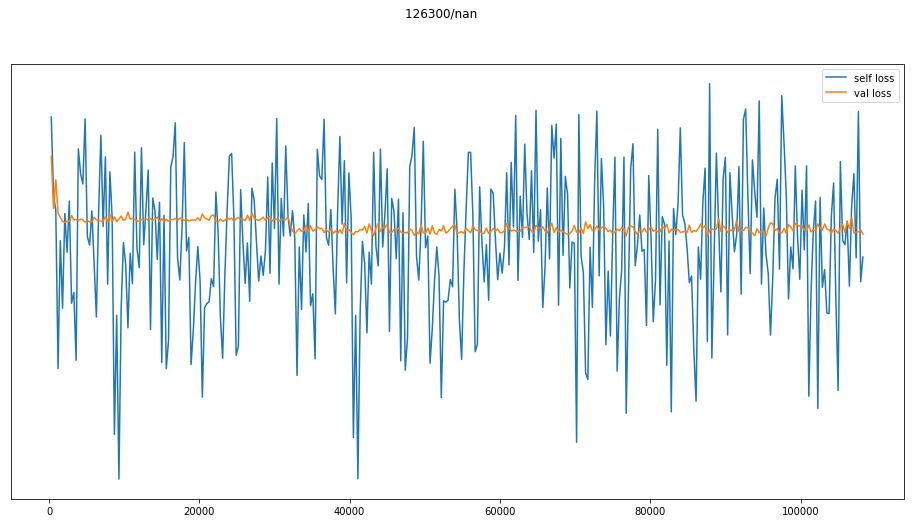

40/40 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 40/100
37760
40/40 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 41/100
37760
40/40 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 42/100
37760
40/40 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 43/100
37760
40/40 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 44/100
37760
40/40 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 45/100
37760
40/40 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 46/100
37760
40/40 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 47/100
37760
40/40 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 48/100
37760
40/40 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 49/100
37760
40/40 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 50/100
37760

40/40 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 18/100
37840
40/40 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 19/100
37840
40/40 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 20/100
37840
40/40 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 21/100
37840
40/40 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 22/100
37840
40/40 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 23/100
37840
40/40 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 24/100
37840
40/40 [==============================] - 0s - loss: nan - val_loss: nan
Epoch 25/100


KeyboardInterrupt: 

In [49]:
chunkSize = 40
epochs=100
prefixThisRound = ""
plot_losses.pltSelf = False
plot_losses.epochs = 300
for i in range(0, int(len(train.SDSS_ID)*1), chunkSize):
    print(i, len(train.SDSS_ID))
    x_train = np.stack([ img_preproc(x) for x in train.SDSS_ID.values[i: (i + chunkSize)]])
    x_train = x_train[:, :, :, newaxis]
    
    x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

    vae.fit(x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None),
           callbacks=[plot_losses])

In [50]:
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space

pred = []
truth = []
for i in range(0, df.shape[0], chunkSize):
# for i in range(0, 2*chunkSize, chunkSize):

    x_test = np.stack([ img_preproc(x) for x in df.SDSS_ID.values[i: (i + chunkSize)]])
    x_test = x_test[:, :, :, newaxis]
    y_test = df.logMstar.values[i: (i + chunkSize)]

    x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    pred.append(x_test_encoded)
    truth.append(y_test)

In [41]:
print(i)

78840


In [51]:
pred = np.vstack(pred)
print(pred.shape)
truth = np.hstack(truth)
print(truth.shape)

(78851, 2)
(78851,)


In [54]:
pred[0]

array([ nan,  nan], dtype=float32)

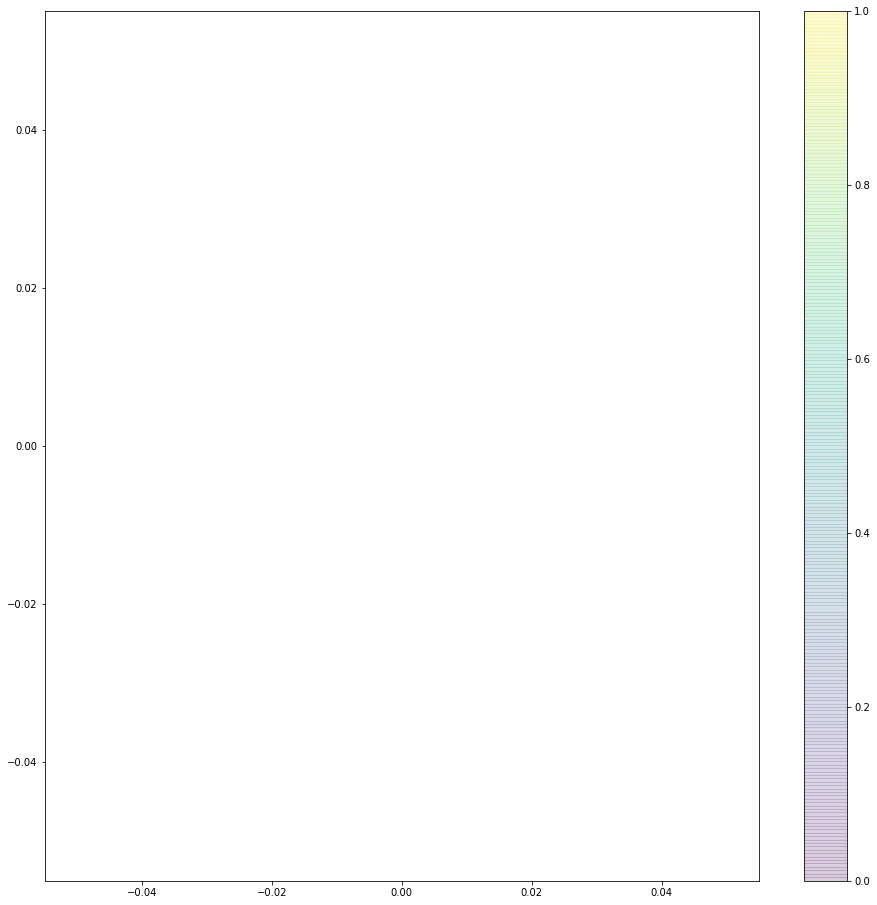

In [52]:
plt.figure(figsize=(16, 16))
plt.scatter(pred[:, 0], pred[:, 1], c=truth, alpha=0.2)
plt.colorbar()
plt.show()

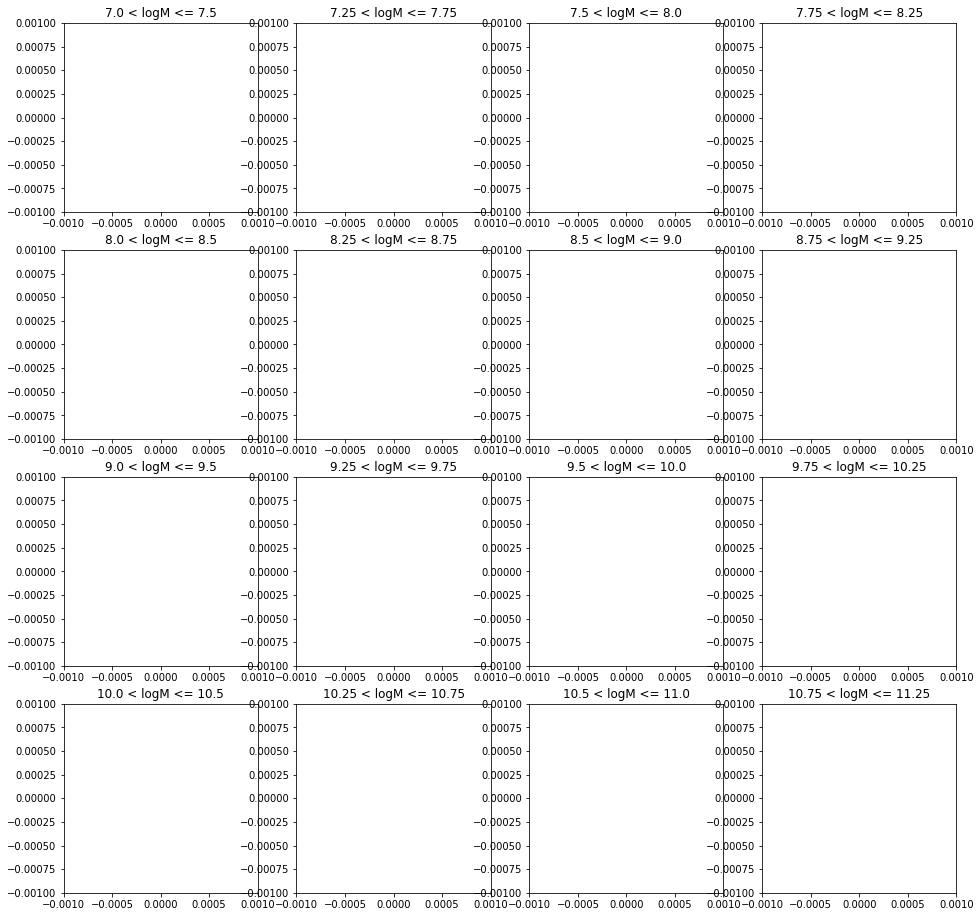

In [53]:
# for bi in range(8, 12)

xxlim = [pred[:,0].min(),pred[:,0].max()]
yylim = [pred[:,1].min(),pred[:,1].max()]


plt.figure(figsize=(16,16))
for i in range(0,16):
    ii = 7+i*(1/4)
    plt.subplot(4,4,i+1)
    plt.title('{} < logM <= {}'.format(ii,ii+0.5))
    idx = np.where([(truth > ii) & (truth <= ii+0.25)])[1]
    plt.scatter(pred[idx, 0], pred[idx, 1], c=truth[idx], alpha=0.2)
    plt.xlim(xxlim)
    plt.ylim(yylim)
    
# plt.colorbar()
plt.show()


In [45]:
print(pred[:,0].min(),pred[:,0].max())
print(pred[:,1].min(),pred[:,1].max())

-8.20477 2.93183
-0.946392 30.4202


In [46]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()


ValueError: Error when checking : expected input_2 to have 2 dimensions, but got array with shape (11, 224, 224, 1)

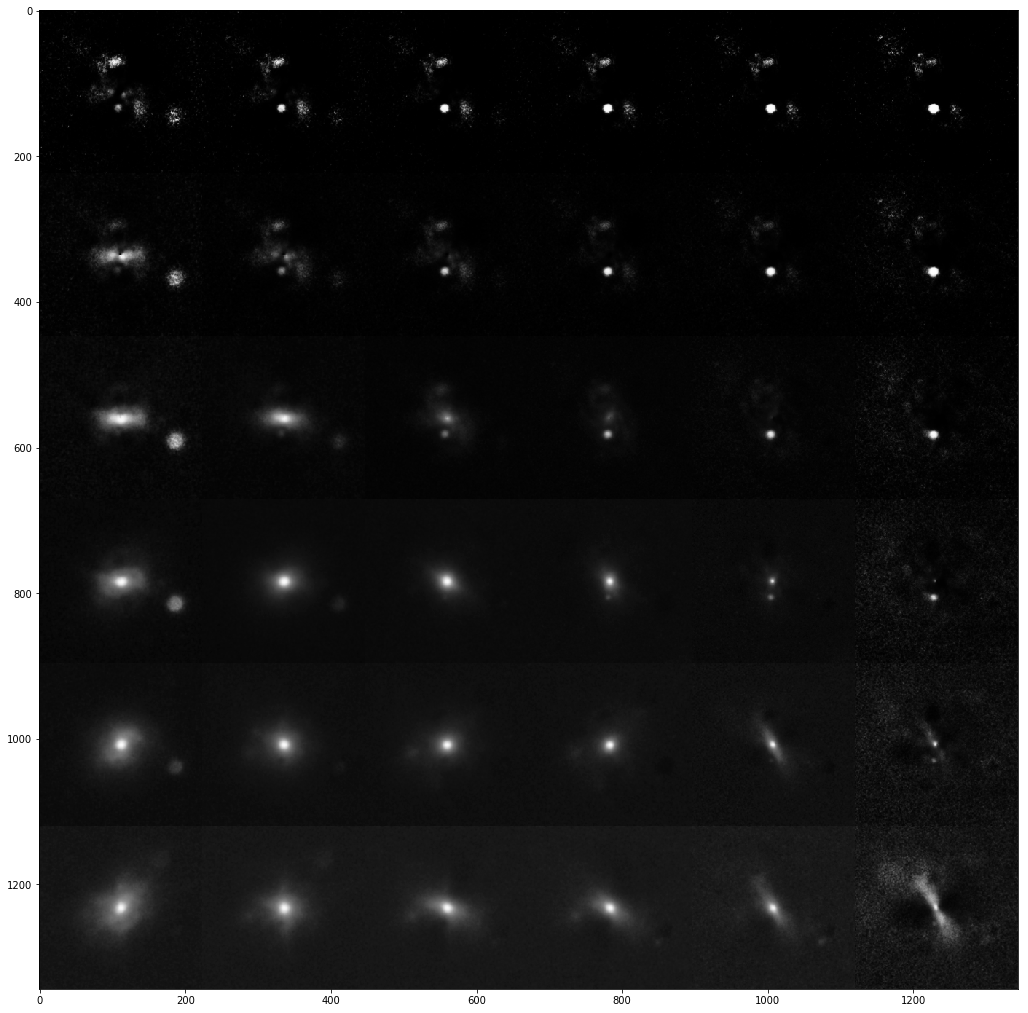

In [48]:

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 6  # figure with 15x15 digits
imgwidth = 224
figure = np.zeros((imgwidth * n, imgwidth * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(imgwidth, imgwidth)
        figure[i * imgwidth: (i + 1) * imgwidth,
               j * imgwidth: (j + 1) * imgwidth] = digit

plt.figure(figsize=(18, 18))
plt.imshow(figure, cmap='Greys_r')
# plt.imshow(figure, cmap='jet')
plt.show()